#  Creating effective investment portfolios

Let's assume we have an investment portfolio containing the following shares:
- Apple
- Proctor and Gamble
- McDonalds
- General Motors
- Exxon Mobil
- General Electric

We would like to know if our portfolio can be enchanced or it is already effective.

First we download the daily closing prices of these stocks from the last 7 years and prepare them for analysis.

In [1]:
%matplotlib inline

import pandas as pd
from pandas_datareader import data
import pandas_datareader
import numpy as np
import scipy as sc
import cvxopt
import portfolioopt as pfopt
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
shares = data.DataReader(['AAPL','PG','MCD','GM','XOM','GE'], 'yahoo',start='1/1/2010')
aapl = data.DataReader('AAPL', 'yahoo',start='1/1/2010')
pg = data.DataReader('PG', 'yahoo',start='1/1/2010')
mcd = data.DataReader('MCD', 'yahoo',start='1/1/2010')
gm = data.DataReader('GM', 'yahoo',start='1/1/2010')
exxon = data.DataReader('XOM', 'yahoo',start='1/1/2010')
ge = data.DataReader('ge', 'yahoo',start='1/1/2010')

We can calculate daily returns based on our daily closing prices. We use asjusted closing prices to take into account changes in the shares (i.e. dividend payment).

In [3]:
aapl["change"]=aapl['Adj Close'].pct_change()
pg["change"]=pg['Adj Close'].pct_change()
mcd["change"]=mcd['Adj Close'].pct_change()
gm["change"]=gm['Adj Close'].pct_change()
exxon["change"]=exxon['Adj Close'].pct_change()
ge["change"]=ge['Adj Close'].pct_change()

We calculate annual returns for the target period.

In [4]:
aapl_days = (aapl.index[-1] - aapl.index[0]).days
aapl_cagr = ((((aapl['Adj Close'][-1]) / aapl['Adj Close'][1])) ** (365.0/aapl_days)) - 1
pg_days = (pg.index[-1] - pg.index[0]).days
pg_cagr = ((((pg['Adj Close'][-1]) / pg['Adj Close'][1])) ** (365.0/pg_days)) - 1
exxon_days = (exxon.index[-1] - exxon.index[0]).days
exxon_cagr = ((((exxon['Adj Close'][-1]) / exxon['Adj Close'][1])) ** (365.0/exxon_days)) - 1
#GM doesn't have values for the beginig of the series so we take the first valid day they when it did
gm_days = (gm.index[-1] - gm.first_valid_index()).days
gm_cagr = ((((gm['Adj Close'][-1]) / gm['Adj Close'][1])) ** (365.0/gm_days)) - 1
mcd_days = (mcd.index[-1] - mcd.index[0]).days
mcd_cagr = ((((mcd['Adj Close'][-1]) / mcd['Adj Close'][1])) ** (365.0/mcd_days)) - 1
ge_days = (ge.index[-1] - ge.index[0]).days
ge_cagr = ((((ge['Adj Close'][-1]) / ge['Adj Close'][1])) ** (365.0/ge_days)) - 1

We also calculate volatility that shows us how risky an asset is.

In [5]:
aapl_vol = aapl['change'].std()*sqrt(252)
pg_vol = pg['change'].std()*sqrt(252)
exxon_vol = exxon['change'].std()*sqrt(252)
gm_vol = gm['change'].std()*sqrt(252)
mcd_vol = mcd['change'].std()*sqrt(252)
ge_vol = ge['change'].std()*sqrt(252)

In [6]:
portfolio=pd.DataFrame({'mu':[aapl_cagr,pg_cagr,exxon_cagr,gm_cagr,mcd_cagr,ge_cagr],
                        "vol":[aapl_vol,pg_vol,exxon_vol,gm_vol,mcd_vol,ge_vol]},
                      index=['Apple',"P&G","EXXON","GM","McDonalds","GE"])

Let's see summarized results. ( * "mu" * represents return)

In [7]:
portfolio

,mu,vol
Apple,0.229648,0.261516
P&G,0.079473,0.142722
EXXON,0.061075,0.188850
GM,0.035433,0.292710
McDonalds,0.136095,0.151711
GE,0.142124,0.217664


Let's create random weights for our imaginary portfolio

In [8]:
np.random.seed(472)
portfolio_comp=np.random.rand(6)
portfolio_comp=portfolio_comp/portfolio_comp.sum()
portfolio_comp
portfolio["share"]=portfolio_comp
portfolio

,mu,vol,share
Apple,0.229648,0.261516,0.220429
P&G,0.079473,0.142722,0.279298
EXXON,0.061075,0.188850,0.157666
GM,0.035433,0.292710,0.213100
McDonalds,0.136095,0.151711,0.030743
GE,0.142124,0.217664,0.098763


We would like to analyze the performance of our portfolio. We need a covariance matrix for that. It will show us how the price of the different assets moves compared to each other.

In [9]:
share_returns=pd.DataFrame()
share_returns["aapl"]=aapl["change"]
share_returns["pge"]=pg["change"]
share_returns["exxon"]=exxon["change"]
share_returns["gm"]=gm["change"]
share_returns["mcd"]=mcd["change"]
share_returns["ge"]=ge["change"]
share_returns=share_returns.cov()
share_returns

,aapl,pge,exxon,gm,mcd,ge
aapl,0.000271,0.000043,0.000067,0.000097,0.000051,0.000086
pge,0.000043,0.000081,0.000052,0.000052,0.000037,0.000057
exxon,0.000067,0.000052,0.000142,0.000098,0.000049,0.000099
gm,0.000097,0.000052,0.000098,0.000340,0.000056,0.000124
mcd,0.000051,0.000037,0.000049,0.000056,0.000091,0.000061
ge,0.000086,0.000057,0.000099,0.000124,0.000061,0.000188


The return of our portfolio is simply the weighted average of the assets' returns. But we have to be careful we cannot use the same logic for volatility. It is becuase the movement of the different assets can counterbalance each other so the volatility of our portfolio will be lower than the weighted average. That is one of the main argument to keep our investment in a portfolio and not just in the shares of a simple company.

In [10]:
portfolio_volatility = np.sqrt(portfolio_comp.dot(share_returns.values).dot(portfolio_comp.T))*sqrt(252)
portfolio_return=np.array(portfolio["mu"]).T.dot(np.array(portfolio_comp))
print("The volatility of our current portfolio: {:.4f} ".format(portfolio_volatility))
print("The return of our current portfolio: {:.4f} ".format(portfolio_return))

The volatility of our current portfolio: 0.1546 
The return of our current portfolio: 0.1082 


In exchange for accepting higher risk we usually expect higher returns while from very reliable companies we accept lower returns. 

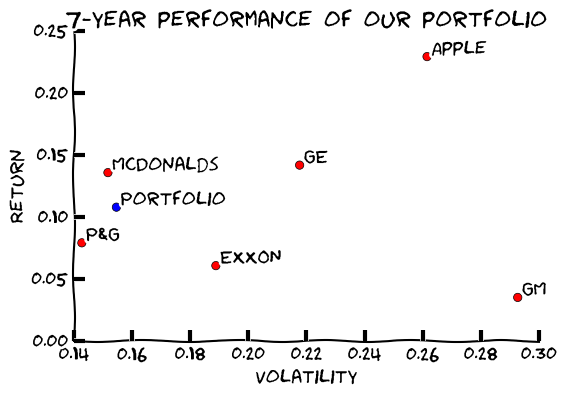

In [24]:
label=portfolio.index.values
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xkcd()
plt.plot(portfolio.vol.values,portfolio.mu.values,'ro')
plt.plot(portfolio_volatility,portfolio_return,'bo')
plt.ylabel('Return')
plt.xlabel('Volatility')
plt.title("7-year performance of our portfolio")
for x in range(len(label)):
    plt.annotate(label[x], xy = (portfolio.vol.values[x], portfolio.mu.values[x]), xytext = (3, 3), textcoords = 'offset points')
plt.annotate("Portfolio", xy = (portfolio_volatility, portfolio_return), xytext = (3, 3), textcoords = 'offset points')    
plt.show()

The results are very interesting. GM has the highest volatility (risk) while it provides the lowest return. It doesn't seems like a good investment. Apple has a high return and we have to accept risk acordingly. Though Exxon has a medium volatility both P&G and McDonalds provide higher return for lower risk. Unfortunately our portfolio also seems suboptimal. McDonalds has lower volatility but higher return. It urges us to optimize our portfolio.

Before that let's examine what can we expect from our portfolio in the upcomming year. We can see below how our portfolio performed historicaly but how will it perform in the future?

In [12]:
weighted_values=np.asarray(shares['Adj Close'].fillna(method="bfill"))*portfolio_comp
shares['Adj Close']["portfolio"]=np.sum(weighted_values, axis=1)

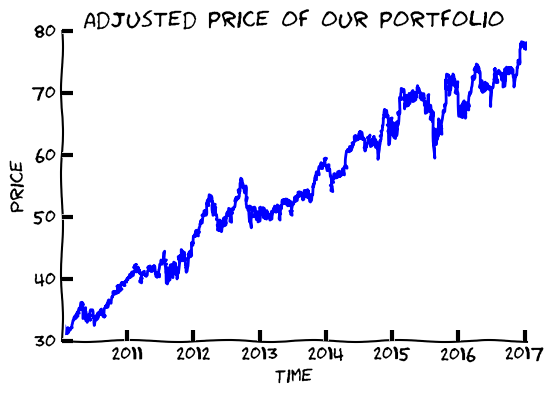

In [13]:
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xkcd()
plt.plot(shares['Adj Close']["portfolio"])
plt.ylabel('Price')
plt.xlabel('Time')
plt.title("Adjusted price of our portfolio")
plt.show()

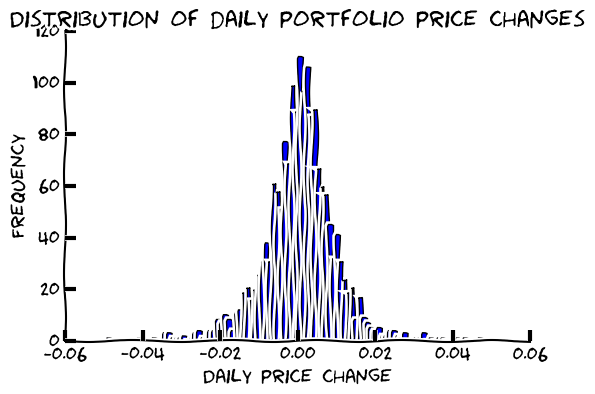

In [14]:
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xkcd()
plt.xlabel('Daily price change')
plt.ylabel('Frequency')
plt.title("Distribution of daily portfolio price changes")
plt.hist(shares['Adj Close']["portfolio"].pct_change().dropna().values,100)
plt.show()

## Monte Carlo analysis

We can make a monte carlo analysis where we simulate 10.000 random scenarios for the daily changes of our portfolio for the next year. Random numbers are selected from a normal distribution where parameters are set based on historical performance. Please note that though normal distribution is a common choice it is not the perfect solution. It's tail is too narrow so may underestimate possible extreme changes.

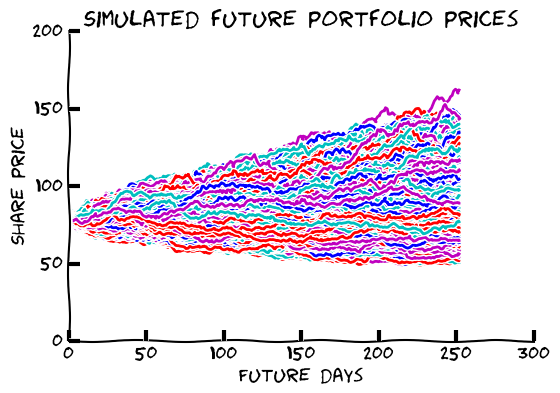

In [15]:
#set up empty list to hold our ending values for each simulated price series
result = []
 
#Define Variables
S = shares['Adj Close']["portfolio"][-1] #starting stock price (i.e. last available real stock price)
T = 252 #Number of trading days
mu = portfolio_return #Return
vol = portfolio_volatility #Volatility

fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
 
#choose number of runs to simulate - I have chosen 10,000
for i in range(10000):
    #create list of daily returns using random normal distribution
    daily_returns=np.random.normal((1+mu)**(1/T),vol/sqrt(T),T)
    #daily_returns=np.random.normal(aapl['change'].mean(),vol/sqrt(T),T)+1
 
    #set starting price and create price series generated by above random daily returns
    price_list = [S]
 
    for x in daily_returns:
        price_list.append(price_list[-1]*x)
 
    #plot data from each individual run which we will plot at the end
    plt.plot(price_list)
 
    #append the ending value of each simulated run to the empty list we created at the beginning
    result.append(price_list[-1])
 
#show the plot of multiple price series created above
plt.xlabel('Future days')
plt.ylabel('Share price')
plt.title("Simulated future portfolio prices")
plt.ylim([0,200])
plt.show()

Aggregating the results of the scenarios will define the expected value of the portfolio. We can also estimate how our value will change in an optimistic and a pessimistic case.

In [16]:
print("Expected price=",np.mean(result))
print("5% quantile =",np.percentile(result,5))
print("95% quantile =",np.percentile(result,95))

Expected price= 86.4866826089
5% quantile = 66.0382935917
95% quantile = 109.770663116


As we can see below there's only 5 chance for the price to go below 66 dollar but also only 5 to go above $110.

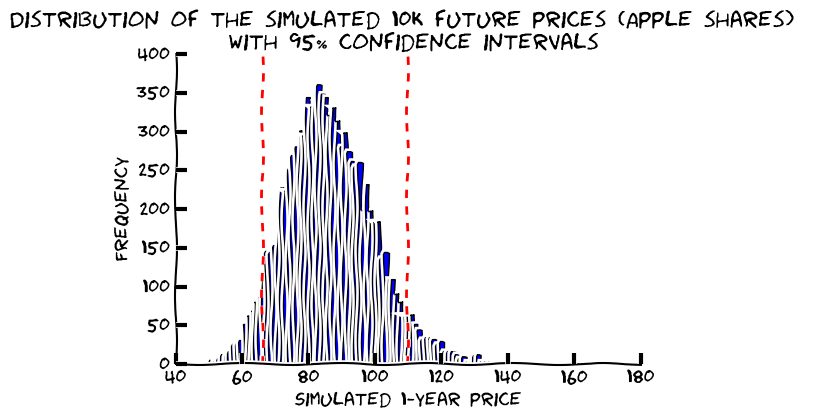

In [17]:
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.hist(result,bins=100)
plt.axvline(np.percentile(result,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(result,95), color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Simulated 1-year price')
plt.ylabel('Frequency')
plt.title("Distribution of the simulated 10k future prices (Apple shares) \n with 95% confidence intervals")
plt.show()

## Optimizing our portfolio

As we saw earlier our portfolio seemed suboptimal in respect of the Return/Volatility trade-off. We can rearange our portfolio to provide the same return but for a lower risk. These optimal portfolios which minimize risk for a certain return are called Markowitz portfolios. Certainly there are several Markowitz portfolios. The one that provides the return of our portfolio looks like this (for simplicity we rounded numbers):

In [18]:
avg_rets= portfolio["mu"]
target_ret=portfolio_return
cov_mat=share_returns
cov_mat.index=avg_rets.index
weights = pfopt.markowitz_portfolio(cov_mat, avg_rets, target_ret, allow_short=False)
round(weights,2)
for item in range(len(weights)):
    if weights[item]<0.02:
        weights[item]=0
weights=weights/weights.sum()
round(weights,2)

Apple        0.06
P&G          0.47
EXXON        0.07
GM           0.00
McDonalds    0.39
GE           0.00
dtype: float64

From the new portfolio we completly eliminated GE and GM stocks. If we remember for the performance of GM we are probably not surprised. If we compare our new portfolio to the old one we still get the same return but by running a lower risk.

In [19]:
new_portfolio_volatility = np.sqrt(weights.dot(share_returns.values).dot(weights.T))*sqrt(252)
new_portfolio_return=np.array(portfolio["mu"]).T.dot(np.array(weights))
print("The volatility of the redesigned portfolio: {:.4f} while the original was {:.4f}".
      format(new_portfolio_volatility,portfolio_volatility))
print("The return of our current portfolio: {:.4f} ".format(new_portfolio_return))

The volatility of the redesigned portfolio: 0.1224 while the original was 0.1546
The return of our current portfolio: 0.1090 


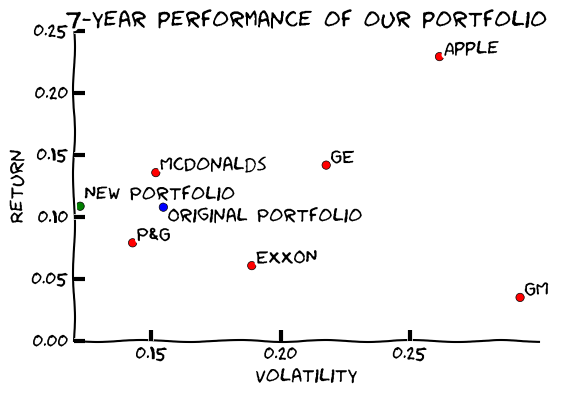

In [20]:
label=portfolio.index.values
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xkcd()
plt.plot(portfolio.vol.values,portfolio.mu.values,'ro')
plt.plot(portfolio_volatility,portfolio_return,'bo')
plt.plot(new_portfolio_volatility,new_portfolio_return,'go')
plt.ylabel('Return')
plt.xlabel('Volatility')
plt.title("7-year performance of our portfolio")
for x in range(len(label)):
    plt.annotate(label[x], xy = (portfolio.vol.values[x], portfolio.mu.values[x]), xytext = (3, 3), textcoords = 'offset points')
plt.annotate("New Portfolio", xy = (new_portfolio_volatility, new_portfolio_return), xytext = (3, 6), textcoords = 'offset points')    
plt.annotate("Original Portfolio", xy = (portfolio_volatility, portfolio_return), xytext = (3, -9), textcoords = 'offset points')    
plt.show()

As we could see every portfolio has a risk and an associated return. Return/Risk ratio is called *Sharpe ratio*. The portfolio with the highest Sharpe ratio is called *Tangency portfolio*. Let's find our tangency portfolio.

In [21]:
avg_rets= portfolio["mu"]
cov_mat=share_returns
cov_mat.index=avg_rets.index

tangency_weights = pfopt.tangency_portfolio(cov_mat, avg_rets)
tangency_weights = pfopt.truncate_weights(tangency_weights) 
tangency_weights

Apple        0.320193
P&G          0.065724
EXXON        0.000000
GM           0.000000
McDonalds    0.553830
GE           0.060252
dtype: float64

In [22]:
tangency_portfolio_volatility = np.sqrt(tangency_weights.dot(share_returns.values).dot(tangency_weights.T))*sqrt(252)
tangency_portfolio_return=np.array(portfolio["mu"]).T.dot(np.array(tangency_weights))
print("The volatility of the tangency portfolio: {:.4f} while the original was {:.4f}".
      format(tangency_portfolio_volatility,portfolio_volatility))
print("The return of tangency portfolio: {:.4f} while the original was {:.4f}".format(tangency_portfolio_return, portfolio_return))

The volatility of the tangency portfolio: 0.1484 while the original was 0.1546
The return of tangency portfolio: 0.1627 while the original was 0.1082


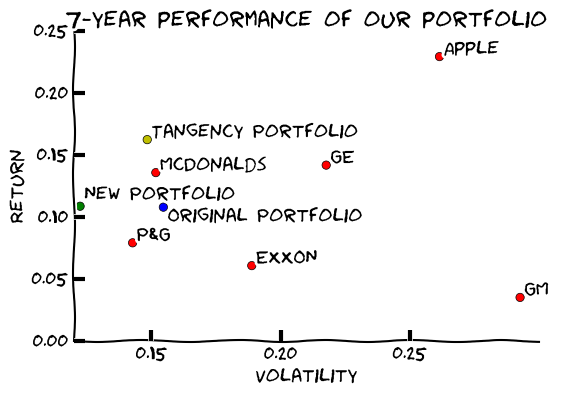

In [23]:
label=portfolio.index.values
fig, ax = plt.subplots()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xkcd()
plt.plot(portfolio.vol.values,portfolio.mu.values,'ro')
plt.plot(portfolio_volatility,portfolio_return,'bo')
plt.plot(new_portfolio_volatility,new_portfolio_return,'go')
plt.plot(tangency_portfolio_volatility,tangency_portfolio_return,'yo')
plt.ylabel('Return')
plt.xlabel('Volatility')
plt.title("7-year performance of our portfolio")
for x in range(len(label)):
    plt.annotate(label[x], xy = (portfolio.vol.values[x], portfolio.mu.values[x]), xytext = (3, 3), textcoords = 'offset points')
plt.annotate("New Portfolio", xy = (new_portfolio_volatility, new_portfolio_return), xytext = (3, 6), textcoords = 'offset points')    
plt.annotate("Original Portfolio", xy = (portfolio_volatility, portfolio_return), xytext = (3, -9), textcoords = 'offset points')    
plt.annotate("Tangency Portfolio", xy = (tangency_portfolio_volatility, tangency_portfolio_return), xytext = (3, 3), textcoords = 'offset points')    
plt.show()

Our new tangency portfolio seems like a fair compromise between return and risk.

## Summary

By creating portfolios we can mitigate our risk. But not all portfolio is the same there is always a trade-off between risk and return. We can define effectife Markowitz portfolios where we maximize return on a specific risk level. The portfolio that maximize the Return/Risk ratio is called tangency portfolio. We should carufully monitor our portfolio not to posess a suboptimal one. All said we should not forget that we used historical prices for our calculations that not necesserily have any impact on future prices. So though these techniques can be useful and efficient but apply them carefully.